### Notebook that estimates the number of driver mutations per sample for E3 ligases across TCGA tumor types

### Read data 

In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import numpy as np, scipy.stats as st
import itertools


### paths

In [2]:
base = "../../"

path_output_methods=os.path.join(base,"data","output_methods_selection")
path_dndscv = os.path.join(path_output_methods,"output_dndscv_e3ligases_paper_tcga_tri")
path_input_muts = os.path.join(base,"data","mutations_e3","tcga")
df_drivers_tcga = pd.read_csv( os.path.join(base,"data","signals_E3_ligases_tcga.tsv"),sep="\t")
drivers_e3_tcga = set(df_drivers_tcga[(df_drivers_tcga["oncodrivefml_qvalue"]<0.1)|(df_drivers_tcga["dndscv_qvalue"]<0.1)]["Hugo_Symbol"].unique())
# Data
output_data = os.path.join(base,"data")
path_dictionary_samples = os.path.join(output_data,"dict_excess_per_sample_E3s.json")
# Plots 
path_output_plots = os.path.join(base,"plots","Figure7")


In [3]:
def set_color(row,colors):
    if row["Cancer_Type"] in colors:
        return colors[row["Cancer_Type"]]
    else:
        return "black"

### Get number of samples analyzed per tumor

In [4]:
path_input_muts

'../../data/mutations_e3/tcga'

In [5]:
dict_samples= {}
for filef in glob.glob(path_input_muts+"/"+"*_dndscv.tsv.gz"):
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    ttype = os.path.basename(filef).split(".")[0].split("_")[0]
    df["Cancer_Type"]=ttype
    dict_samples[ttype]=len(df["sampleID"].unique())


In [6]:
dict_samples

{'ACC': 90,
 'BLCA': 406,
 'BRCA': 786,
 'CESC': 279,
 'CHOL': 36,
 'COADREAD': 328,
 'DLBC': 37,
 'ESCA': 182,
 'GBM': 312,
 'HNSC': 504,
 'KICH': 66,
 'KIRC': 368,
 'KIRP': 281,
 'LGG': 510,
 'LIHC': 361,
 'LUAD': 507,
 'LUSC': 476,
 'MESO': 81,
 'OV': 65,
 'PAAD': 176,
 'PAN': 8899,
 'PCPG': 179,
 'PRAD': 494,
 'SARC': 234,
 'SKCM': 450,
 'STAD': 392,
 'TGCT': 145,
 'THCA': 492,
 'THYM': 122,
 'UCEC': 404,
 'UCS': 56,
 'UVM': 80}

### Read output of dndscv and get the global value of dndscv

##### Functions to calculate excess from omega

In [7]:
def excess_muts(n_obs, omega):
    """
    n_obs: int: number of observed mutations of a kind
    omega: float: applicable dnds estimate
    omega: float: applicable dnds estimate
    """
    if (n_obs == 0) or np.isnan(n_obs) or np.isnan(omega):
        return n_obs
    elif 0 <= omega <= 1:
        return 0
    elif omega > 1:
        return round((omega - 1) * n_obs / omega)

def excess_rate(n_obs, omega):
    """
    n_obs: int: number of observed mutations of a kind
    omega: float: applicable dnds estimate
    """
    if (n_obs == 0) or np.isnan(n_obs) or np.isnan(omega):
        return 0
    elif 0 <= omega <= 1:
        return 0
    elif omega > 1:
        return (omega - 1) / omega

def add_excess(df):
    df['excess_mis'] = df.apply(lambda v: excess_muts(v['n_mis'], v['wmis_cv']), axis=1)
    df['excess_non'] = df.apply(lambda v: excess_muts(v['n_non'], v['wnon_cv']), axis=1)
    df['excess_spl'] = df.apply(lambda v: excess_muts(v['n_spl'], v['wspl_cv']), axis=1)
    df['excess_rate_mis'] = df.apply(lambda v: excess_rate(v['n_mis'], v['wmis_cv']), axis=1)
    df['excess_rate_non'] = df.apply(lambda v: excess_rate(v['n_non'], v['wnon_cv']), axis=1)
    df['excess_rate_spl'] = df.apply(lambda v: excess_rate(v['n_spl'], v['wspl_cv']), axis=1)
    return df


### Calculate the excess per cohort per gene

In [8]:
l = []
for filef in glob.glob(path_dndscv+"/"+"*.out.gz"):
    if "annotmuts" in filef or "genemuts" in filef:
        continue
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    

    ttype = os.path.basename(filef).split(".")[0]
    df["Cancer_Type"]=ttype

    df = df[df["gene_name"].isin(drivers_e3_tcga)][['gene_name', 'wmis_cv', 'wnon_cv', 'wspl_cv', 'n_mis', 'n_syn', 'n_spl', 'n_non','Cancer_Type']].drop_duplicates()
    #df.rename(columns={"qglobal_cv":"dndscv_qvalue","gene_name":"Hugo_Symbol"},inplace=True)
    l.append(df)
df_dnds = pd.concat(l)
df_with_excess = add_excess(df_dnds)

### Dictionaries to speed up the calculation of sample-specific excess

In [9]:
dict_missense = {}
dict_non = {}
dict_splice = {}
d_global = {}
for index,row in df_with_excess.iterrows():
    dict_missense[row["gene_name"]+"_"+row["Cancer_Type"]] = row["excess_rate_mis"]
    dict_non[row["gene_name"]+"_"+row["Cancer_Type"]] = row["excess_rate_non"]
    dict_splice[row["gene_name"]+"_"+row["Cancer_Type"]] = row["excess_rate_spl"]
d_global["Missense"] = dict_missense
d_global["Nonsense"] = dict_non
d_global["Essential_Splice"] = dict_splice

### Calculate for each sample the number of driver mutations (number of mutations in excess). Calculate per consequence type and the agggregated one

##### Functions to calculate it

In [10]:
def get_excess_sample(df_grouped,impact,total_samples,ttype,dict_output,dict_samples):
    '''
    df_grouped : dataframe input with the excess grouped by sample, gene and impact. The column pos has the number of mutations per gene per sample. 
    impact: consequence type ["Missense","Nonsense","Essential_Splice"]
    total_samples: total number of samples in this cohrot
    ttype: cancer type
    dict_output: dictionary to fill with the excess of the impact type for this cohort
    dict_samples: diciontary where keys are ttype and samples where its calculated the global excess (excess of mis, non and splice) per sample 
    '''
    df_data = df_grouped[df_grouped["impact"]==impact]

    excess_array = []
    if df_data.shape[0] >0:
        
        # calculate excess as excess_rate * number of mutations per gene per sample
        df_data["excess"]=df_data.apply(lambda row: row["pos"]*d_global[impact][row["gene"]+"_"+row["Cancer_Type"]],axis=1)
        # get sum of missense in excess per sample
        excess_array = list(df_data.groupby("sampleID",as_index=False).agg({"excess":np.nansum})["excess"].values)
        samples = list(df_data.groupby("sampleID",as_index=False).agg({"excess":np.nansum})["sampleID"].values)
        for i in range(0,len(samples)):
            sample = samples[i]
            if sample in dict_samples[ttype]:
                dict_samples[ttype][sample] =  dict_samples[ttype][sample] + excess_array[i]
            else:
                dict_samples[ttype][sample] =  excess_array[i]
        
    # if there is not information is a 0
    zeros = list(np.zeros(total_samples-len(excess_array)))
    total_cohort = zeros +  excess_array
    if not(ttype in dict_output):
        dict_output[ttype]= []
    dict_output[ttype] = dict_output[ttype] + total_cohort
    return dict_output,dict_samples

### Perform the calculation for all tumor types

In [11]:
dict_excess_sample_missense = {}
dict_excess_sample_nonsense = {}
dict_excess_sample_splice = {}
dict_excess_sample_aggregated = {}
dict_samples_local = {}
for filef in glob.glob(path_dndscv+"/"+"*.annotmuts.out.gz"):
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    df = df[df["gene"].isin(drivers_e3_tcga)]
    ttype = os.path.basename(filef).split(".")[0]
    df["Cancer_Type"]=ttype
    if ttype == "COAD" or ttype == "READ":
        continue # Its grouped in COADREAD
    # Get total number of samples
    total_samples = dict_samples[ttype]
    
    dict_samples_local[ttype] = {}
    # Group per sample and gene
    df_grouped = df.groupby(["Cancer_Type","gene","sampleID","impact"],as_index=False).agg({"pos":"count"}) # count mutations in gene per sample
    # Missense
    dict_excess_sample_missense,dict_samples_local=get_excess_sample(df_grouped,"Missense",total_samples,ttype,dict_excess_sample_missense,dict_samples_local)
    # Nonsense
    dict_excess_sample_nonsense,dict_samples_local=get_excess_sample(df_grouped,"Nonsense",total_samples,ttype,dict_excess_sample_nonsense,dict_samples_local)
    # Splice
    dict_excess_sample_splice,dict_samples_local=get_excess_sample(df_grouped,"Essential_Splice",total_samples,ttype,dict_excess_sample_splice,dict_samples_local)
    # dict aggregated
    excess_aggregated_data = list(dict_samples_local[ttype].values())
    zeros = list(np.zeros(total_samples-len(excess_aggregated_data)))
    dict_excess_sample_aggregated[ttype] = list(excess_aggregated_data) + zeros

    


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### save a dictionary per sample 

In [12]:
path_dictionary_samples

'../../data/dict_excess_per_sample_E3s.json'

In [13]:
json.dump(dict_samples_local,open(path_dictionary_samples,'w'))

In [14]:
for ttype in dict_excess_sample_aggregated.keys():
    aggregated = np.nanmean(dict_excess_sample_aggregated[ttype])
    mis = np.nanmean(dict_excess_sample_missense[ttype])
    non = np.nanmean(dict_excess_sample_nonsense[ttype])
    spl = np.nanmean(dict_excess_sample_splice[ttype])
    print (ttype,aggregated,mis,non,spl)

GBM 0.1027065082706379 0.08764713088582339 0.015059377384814535 0.0
OV 0.13329511891335816 0.1032771562534227 0.0 0.030017962659935456
LUAD 0.3580834994137715 0.2933275986665287 0.04719388247403945 0.01756201827320328
LUSC 0.5081322857974915 0.41495675327014286 0.06585366520617901 0.027321867321169698
PRAD 0.17179454725802965 0.1469157153034199 0.022950369236997056 0.001928462717612676
UCEC 0.388074111511634 0.28012335631888563 0.08957150741406368 0.018379247778684583
BLCA 0.32383751950031253 0.23272853668658858 0.08006129545438896 0.011047687359334955
TGCT 0.06551513665797405 0.0517982112928603 0.0 0.013716925365113751
ESCA 0.19240596488893374 0.14300940568643186 0.04500391321712505 0.004392645985376844
PAAD 0.17529576164760002 0.12540906852605138 0.038736138206484666 0.011150554915063969
KIRP 0.11604010495760413 0.08666013192456895 0.025885894077458362 0.0034940789555767994
LIHC 0.12878180795970598 0.10147048473629967 0.02006647071155093 0.007244852511855377
CESC 0.2578388369835918 0

### Tumor type analysis

##### Function to calculate the ci (0.95)

In [15]:
def get_ci95(grp):
    return st.t.interval(0.95, len(grp)-1, loc=np.mean(grp), scale=st.sem(grp))

### Plot it for each tumor type

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


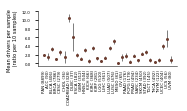

In [19]:
x=sorted(list(dict_excess_sample_aggregated.keys()))
x.remove("PAN")
order = ["PAN"]+x
values = []
ci_ls = []
ci_us = []
for ttype in order:
    mean_excess = np.nanmean(dict_excess_sample_aggregated[ttype])
    values.append(mean_excess)
    ci = get_ci95(dict_excess_sample_aggregated[ttype])
    ci_l = ci[0]
    ci_ls.append(mean_excess-ci_l)
    ci_u = ci[1]
    ci_us.append(ci_u-mean_excess)
fig,ax = plt.subplots(figsize=(2.5,1))
xs = range(0,len(order))

ax.errorbar(xs, values, yerr=[ci_ls,ci_us], ecolor='grey', capthick=5,fmt='o',elinewidth=1,markersize=2,c="#6c3e31ff" )
#ax.scatter(x=xs,y=values,s=5)
ax.set_xticks(xs)
labels = [x+f" ({len(dict_excess_sample_aggregated[x])})" for x in order]
_=ax.set_xticklabels(labels,fontsize=5,rotation=90)
ax.set_yticks(np.arange(0,1.4,0.20))
ax.set_yticklabels(["{:.1f}".format(x*10) for x in np.arange(0,1.4,0.2)],fontsize=4,)
ax.set_ylabel("Mean drivers per sample \n (ratio per 10 samples)",fontsize=5)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.02 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"n_drivers_per_tumor_e3.pdf"),bbox_inches="tight",dpi=100)

### Global analysis

In [45]:
missense_drivers = list(dict_excess_sample_missense.values())
mean_missense = np.nanmean(list(itertools.chain(*missense_drivers)))
ci_l_m,ci_u_m = get_ci95(list(itertools.chain(*missense_drivers)))
nonsense_drivers = list(dict_excess_sample_nonsense.values())
mean_nonsense = np.nanmean(list(itertools.chain(*nonsense_drivers)))
ci_l_n,ci_u_n = get_ci95(list(itertools.chain(*nonsense_drivers)))
splice_drivers = list(dict_excess_sample_splice.values())
mean_splice = np.nanmean(list(itertools.chain(*splice_drivers)))
ci_l_s,ci_u_s = get_ci95(list(itertools.chain(*splice_drivers)))

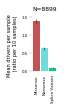

In [43]:
fig,ax = plt.subplots(figsize=(0.45,1.0))
ax.bar(x=0,bottom=0,height=mean_missense,color="#c65353",lw=0.5,yerr=[[mean_missense-ci_l_m,ci_u_m-mean_missense]],error_kw={"linewidth":0.5})
ax.bar(x=1,bottom=0,height=mean_nonsense,color="#70dbdb",lw=0.5,yerr=[[mean_nonsense-ci_l_n,ci_u_n-mean_nonsense]],error_kw={"linewidth":0.5})
ax.bar(x=2,bottom=0,height=mean_splice,color="#00cc99",lw=0.5,yerr=[[mean_splice-ci_l_s,ci_u_s-mean_splice]],error_kw={"linewidth":0.5})
values=list(itertools.chain(*missense_drivers))
#ax.scatter(x=np.zeros(len(values)),y=values,s=0.002,color="#c65353",alpha=0.2)
N=len(dict_excess_sample_missense["PAN"])
ax.set_title("N="+str(N),fontsize=6)
maxv=0.15
ax.set_yticks([x for x in np.arange(0,0.20,0.05)])
ax.set_yticklabels(["{:.1f}".format(x*10) for x in np.arange(0,0.20,0.05)],fontsize=4)
ax.set_ylabel("Mean drivers per sample \n (ratio per 10 samples)",fontsize=5)
ax.set_xlabel("",fontsize=5)
ax.set_xticks([0,1,2])
ax.set_xticklabels(["Missense","Nonsense","Splice Variant"],fontsize=5,rotation=90)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(0.0)
ax.tick_params(axis = 'y', labelsize =4  , pad=0.15 ,width=0.15)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.05 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"./number_drivers_per_consequence_e3.pdf"),bbox_inches="tight",dpi=100)
None

None

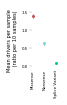

In [37]:
fig,ax = plt.subplots(figsize=(0.45,1.0))
ax.errorbar(x=0,y=mean_missense,color="#c65353",lw=1.5,yerr=[[mean_missense-ci_l_m,ci_u_m-mean_missense]],elinewidth=1.,markersize=2,capthick=5,fmt='o',ecolor='grey')
ax.errorbar(x=1,y=mean_nonsense,color="#70dbdb",lw=1.5,yerr=[[mean_nonsense-ci_l_n,ci_u_n-mean_nonsense]],elinewidth=1.,markersize=2,capthick=5,fmt='o',ecolor='grey')
ax.errorbar(x=2,y=mean_splice,color="#00cc99",lw=1.5,yerr=[[mean_splice-ci_l_s,ci_u_s-mean_splice]],elinewidth=1.,markersize=2,capthick=5,fmt='o',ecolor='grey')



maxv=0.15
ax.set_yticks([x for x in np.arange(0,0.20,0.05)])
ax.set_yticklabels(["{:.1f}".format(x*10) for x in np.arange(0,0.20,0.05)],fontsize=4)
ax.set_ylabel("Mean drivers per sample \n (ratio per 10 samples)",fontsize=5)
ax.set_xlabel("",fontsize=5)
ax.set_xticks([0,1,2])
ax.set_xticklabels(["Missense","Nonsense","Splice Variant"],fontsize=5,rotation=90)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(0.0)
ax.tick_params(axis = 'y', labelsize =4  , pad=0.15 ,width=0.15)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.05 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"./number_drivers_per_consequence_e3.pdf"),bbox_inches="tight",dpi=100)
None

None